對高解析度圖的解決方向:
1. 只對一小部分的地方做Alignment(效果不佳)
2. 對圖片做resize,再對resized照片做alignment(效果不佳)
3. 對圖片的高斯金字塔從小張到大張做alignment,慢慢累積translation

Processing pyramid level 5, time: 0.0195s
Processing pyramid level 4, time: 0.0635s
Processing pyramid level 3, time: 0.3309s
Processing pyramid level 2, time: 1.2484s
Processing pyramid level 1, time: 5.5506s
Processing pyramid level 0, time: 22.0340s


(Text(0.5, 1.0, 'Result'), (-0.5, 3330.5, 3111.5, -0.5))

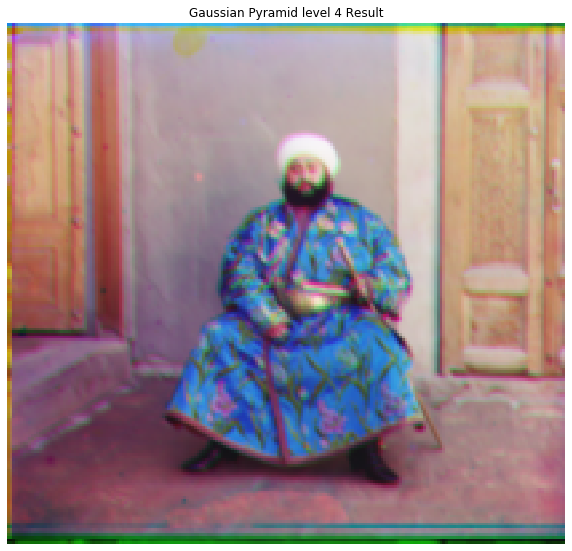

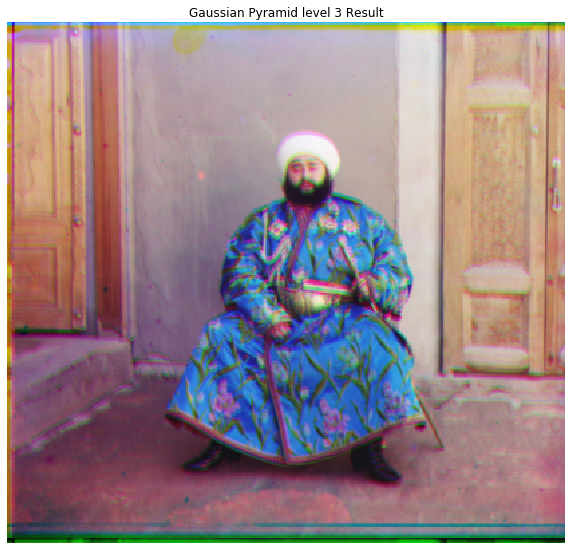

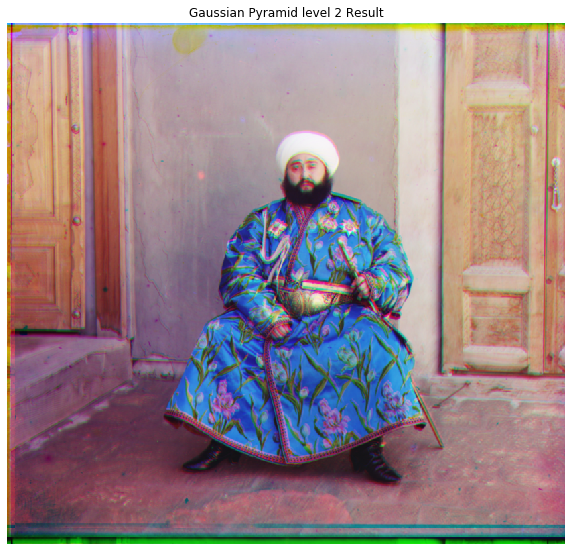

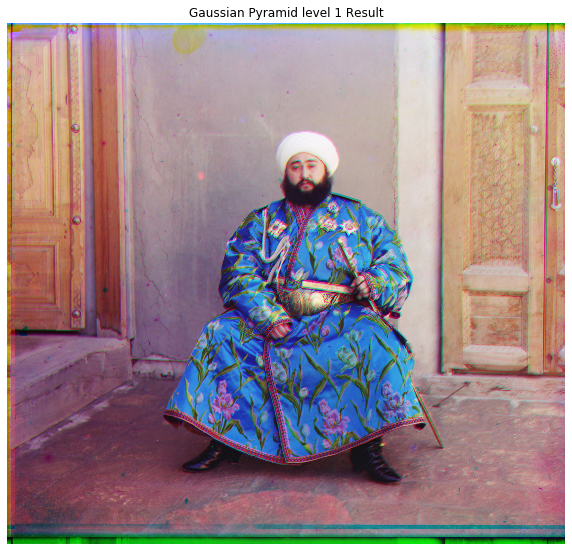

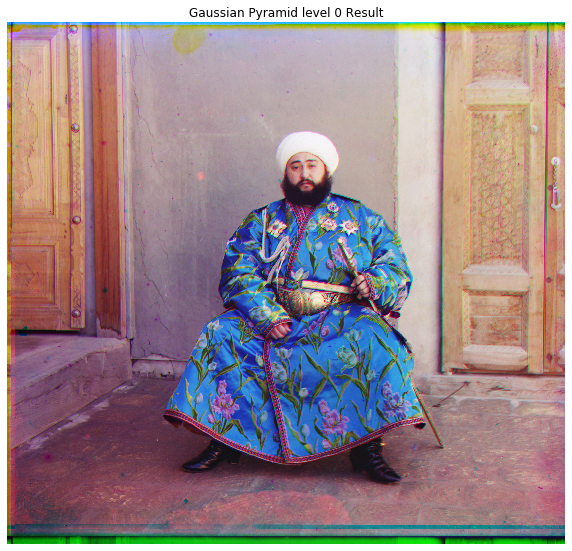

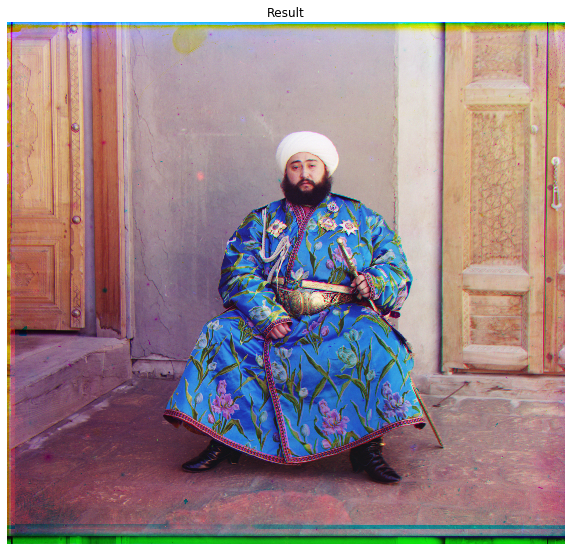

In [41]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time

def ncc(a,b):
    return np.sum(((a/(np.linalg.norm(a)**2)) * (b/(np.linalg.norm(b)**2))))

def nccAlign(a, b, t):
    max_ncc = -1
    ivalue=np.linspace(-t,t,2*t,dtype=int)
    jvalue=np.linspace(-t,t,2*t,dtype=int)
    for i in ivalue:
        for j in jvalue:
            nccDiff = ncc(a,np.roll(b,[i,j],axis=(0,1)))
            if nccDiff > max_ncc:
                max_ncc = nccDiff
                output = [i,j]
    return np.array(output)
def ssd(a,b):
    return np.sum(np.square(a-b))

def ssdAlign(a, b, t):
    max_ncc = -1
    ivalue=np.linspace(-t,t,2*t,dtype=int)
    jvalue=np.linspace(-t,t,2*t,dtype=int)
    for i in ivalue:
        for j in jvalue:
            nccDiff = ncc(a,np.roll(b,[i,j],axis=(0,1)))
            if nccDiff > max_ncc:
                max_ncc = nccDiff
                output = [i,j]
    return np.array(output)

img = cv2.imread('hw2_data/task3_colorizing/emir.tif',cv2.IMREAD_GRAYSCALE)
h, w = img.shape
shaved_img = img[int(h*0.01):int(h-h*0.02),int(w*0.05):int(w-w*0.05)]
h = shaved_img.shape[0] // 3
B = shaved_img[0:h,:]
G = shaved_img[h:2*h,:]
R = shaved_img[2*h:3*h,:]
h, w = B.shape

#B = B[h//2:,w//2:]
#G = G[h//2:,w//2:]
#R = R[h//2:,w//2:]

B_GP, G_GP, R_GP = [], [], []
B_GP.append(B)
G_GP.append(G)
R_GP.append(R)
while h > 128:
    B_GP.append(cv2.pyrDown(B_GP[-1]))
    G_GP.append(cv2.pyrDown(G_GP[-1]))
    R_GP.append(cv2.pyrDown(R_GP[-1]))
    h, w = B_GP[-1].shape
GtoB, RtoB = np.zeros(2,dtype=int), np.zeros(2,dtype=int)
i = len(G_GP)-1
while i >= 0:
    print("Processing pyramid level",i,end=', ')
    start = time.time()
    GtoB, RtoB = GtoB*2, RtoB*2
    G_GP[i] = np.roll(G_GP[i],GtoB,axis=(0,1))
    R_GP[i] = np.roll(R_GP[i],RtoB,axis=(0,1))
    if i < len(G_GP)-1:
        result = (np.dstack((R_GP[i],G_GP[i],B_GP[i]))).astype(np.uint8)
        plt.figure(figsize=(10,10)), plt.imshow(result)
        plt.title('Gaussian Pyramid level '+str(i)+' Result'), plt.axis('off')
    
    B_, G_, R_ = B_GP[i], G_GP[i], R_GP[i]
    alignGtoB = ssdAlign(B_,G_,3)
    alignRtoB = ssdAlign(B_,R_,3)
    GtoB += alignGtoB
    RtoB += alignRtoB
    i -= 1
    end = time.time()
    if i == len(G_GP)-1:
        G_GP[i] = np.roll(G_GP[i],GtoB,axis=(0,1))
        R_GP[i] = np.roll(R_GP[i],RtoB,axis=(0,1))
        result = (np.dstack((R_GP[i],G_GP[i],B_GP[i]))).astype(np.uint8)
        plt.figure(figsize=(10,10)), plt.imshow(result)
        plt.title('Gaussian Pyramid level '+str(i)+' Result'), plt.axis('off')
    print("time: %.4fs"%(end - start))
#h = shaved_img.shape[0] // 3
#B = shaved_img[0:h,:]
#G = shaved_img[h:2*h,:]
#R = shaved_img[2*h:3*h,:]
G = np.roll(G,GtoB,axis=(0,1))
R = np.roll(R,RtoB,axis=(0,1))
result = (np.dstack((R,G,B))).astype(np.uint8)
plt.figure(figsize=(10,10)), plt.imshow(result)
plt.title('Result'), plt.axis('off')

In [37]:
dst = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
cv2.imwrite('Result_village.tiff',dst)

True